In [1]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.3/642.3 kB 1.9 MB/s eta 0:00:00m-:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.4/588.4 kB 1.6 MB/s eta 0:00:00m-:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.5/622.5 kB 1.8 MB/s eta 0:00:00m-:--:--


In [1]:
import pandas as pd
import sys
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import numpy as np
import torch
import torch_geometric
from torch_geometric.loader import LinkNeighborLoader
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../graph/')
from query import to_csv, execute_query, to_tensor

**Data Fetching**

In [4]:
# co-authorship
q = """
  MATCH (:Country {name:'Thailand'})<-[]-()<-[]-(a1:Author)-[]->(:Literature)<-[]-(a2:Author)-[]->()-[]->(:Country {name:'Thailand'})
  WHERE a1.id <> a2.id RETURN toInteger(a1.id), toInteger(a2.id);
"""
to_csv(q, 'auth_auth.csv')

2025-01-17 10:08:40.367 | INFO     | query:to_csv:29 - Wrote to file.


In [16]:
# Author -> Literature -> Keyword
co_auth = pd.read_csv("csv/auth_auth.csv")
auth_ids = np.unique(co_auth.to_numpy())
co_edge_index = co_auth.to_numpy().T

props =[{"id": str(id) } for id in auth_ids]

q = f"""
UNWIND $props AS map
MATCH (a: Author {{id: map.id}})-[]->(l:Literature)-[]->(k:Keyword)
RETURN a.id,l.id,k.id
"""

to_csv(q,'auth_lit_key.csv', {"props": props})

2025-01-17 10:44:26.103 | INFO     | query:to_csv:29 - Wrote to file.


In [3]:
auth_lit_key = pd.read_csv("csv/auth_lit_key.csv")

In [181]:
# Literature embeddings
lit_ids = np.unique(auth_lit_key.drop(columns=['a.id', 'k.id']).to_numpy())
props = [{"id": str(id)} for id in lit_ids]
q = f"""
UNWIND $props AS map
MATCH (l:Literature {{id: map.id}})
RETURN l.id, l.embedding
"""

to_tensor(q,'l','lit_feats', {"props": props})

In [7]:
# Keyword embeddings
lit_ids = np.unique(auth_lit_key.drop(columns=['a.id', 'k.id']).to_numpy())
props = [{"id": str(id)} for id in lit_ids]
q = f"""
UNWIND $props AS map
MATCH (:Literature {{id: map.id}})-[]->(k:Keyword)
RETURN k.id, k.embedding
"""

to_tensor(q,'k','key_feats', {"props": props})

In [29]:
key = pd.read_csv("csv/index_key_feats.csv").rename(columns={'Unnamed: 0': 'k.id', 'k.id':'Name'})
alt_ids = auth_lit_key.rename(columns={'k.id': 'Name'}).merge(key, left_on='Name', right_on='Name').drop(columns=['Name'])
alt_ids.to_csv('csv/auth_lit_key.csv')

**Dataset**

In [3]:
auth_lit_key = pd.read_csv('csv/auth_lit_key.csv').drop(columns=['Unnamed: 0'])

lit_ids =  torch.arange(auth_lit_key['l.id'].drop_duplicates().shape[0]) 
key_ids = torch.arange(auth_lit_key['k.id'].drop_duplicates().shape[0]) 
auth_ids = torch.arange(auth_lit_key['a.id'].drop_duplicates().shape[0])  

lit_feats = torch.load("csv/lit_feats.pt").clone().detach().requires_grad_(True) 
key_feats = torch.load("csv/key_feats.pt").clone().detach().requires_grad_(True)

/var/folders/cc/rnt3w6p15_9bhmg17qtpnjlw0000gn/T/ipykernel_62867/1506911503.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lit_feats = torch.load("csv/lit_feats.pt").cl

In [4]:
assert lit_feats.shape[0] == lit_ids.shape[0]
assert key_feats.shape[0] == key_ids.shape[0]

In [5]:
pd.DataFrame(auth_lit_key['a.id'].drop_duplicates().to_numpy(), columns=['id']).to_csv("csv/index_auth.csv")
lit_index = pd.read_csv("csv/index_lit_feats.csv")
auth_index = pd.read_csv("csv/index_auth.csv")

In [6]:
auth_edge_index = pd.concat([auth_lit_key['a.id'].apply(lambda x : int(auth_index[auth_index['id'] == x].index.item())), 
          auth_lit_key['l.id'].apply(lambda x : int(lit_index[lit_index['l.id'] == x].index.item()))], axis=1).drop_duplicates()
key_edge_index = pd.concat([auth_lit_key['l.id'].apply(lambda x : int(lit_index[lit_index['l.id'] == x].index.item())),
                           auth_lit_key['k.id']], axis=1).drop_duplicates()

In [7]:
def get_index(id):
    matches = auth_index[auth_index['id'] == id].index
    if len(matches) == 1:
        return int(matches.item())
    else:
        # prepare to drop auth_id that is not connected to key; (co_auth_edge is fetched without that constraint)
        return None

co_edge_index = pd.read_csv("csv/auth_auth.csv").map(lambda x :  get_index(x)).drop_duplicates().dropna()

In [8]:
auth_edge_index = torch.tensor(auth_edge_index.to_numpy().T)
key_edge_index = torch.tensor(key_edge_index.to_numpy().T)
co_edge_index = torch.tensor(co_edge_index.to_numpy().T).type(torch.int64)

In [9]:
data = HeteroData()

# indices
data['Literature'].node_id = lit_ids 
data['Author'].node_id = auth_ids 
data['Keyword'].node_id = key_ids 

# features
data['Literature'].x = lit_feats
data['Keyword'].x = key_feats

# edges
data['Author', 'AUTHORED', 'Literature'].edge_index = auth_edge_index
data['Literature', 'USED_KEYWORD', 'Keyword'].edge_index = key_edge_index
data['Author', 'CO_AUTHORED', 'Author'].edge_index = co_edge_index

In [10]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('Author', 'CO_AUTHORED', 'Author')

)

train, val, test = transform(data)

In [11]:
train_loader = LinkNeighborLoader(
    data=train,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("Author", "CO_AUTHORED", "Author"), train["Author", "CO_AUTHORED", "Author"].edge_label_index),
    edge_label=train["Author", "CO_AUTHORED", "Author"].edge_label,
    batch_size=128,
    shuffle=True,
)

sampled = next(iter(train_loader))

In [12]:
sampled

HeteroData(
  Literature={
    node_id=[0],
    x=[0, 1536],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  Author={
    node_id=[2220],
    n_id=[2220],
    num_sampled_nodes=[3],
  },
  Keyword={
    node_id=[0],
    x=[0, 1536],
    n_id=[0],
    num_sampled_nodes=[3],
  },
  (Author, AUTHORED, Literature)={
    edge_index=[2, 0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (Literature, USED_KEYWORD, Keyword)={
    edge_index=[2, 0],
    e_id=[0],
    num_sampled_edges=[2],
  },
  (Author, CO_AUTHORED, Author)={
    edge_index=[2, 6710],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[6710],
    num_sampled_edges=[2],
    input_id=[128],
  }
)

**Model**

In [13]:
from train.graph_model import Model # see: graph_model.py

model = Model(64, data=data)

**Training**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(50):

    total_loss = total_examples = 0
    for sampled in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled.to(device)
        pred = model(sampled)

        ground_truth = sampled['Author', 'CO_AUTHORED', 'Author'].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    losses.append(total_loss)
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")
        

100%|██████████| 32/32 [00:00<00:00, 108.11it/s]


Epoch: 000, Loss: 0.9582


100%|██████████| 32/32 [00:00<00:00, 157.86it/s]


Epoch: 001, Loss: 0.6885


100%|██████████| 32/32 [00:00<00:00, 215.97it/s]


Epoch: 002, Loss: 0.6623


100%|██████████| 32/32 [00:00<00:00, 240.09it/s]


Epoch: 003, Loss: 0.6353


100%|██████████| 32/32 [00:00<00:00, 188.91it/s]


Epoch: 004, Loss: 0.6240


100%|██████████| 32/32 [00:00<00:00, 181.79it/s]


Epoch: 005, Loss: 0.6041


100%|██████████| 32/32 [00:00<00:00, 167.56it/s]


Epoch: 006, Loss: 0.5995


100%|██████████| 32/32 [00:00<00:00, 235.60it/s]


Epoch: 007, Loss: 0.5953


100%|██████████| 32/32 [00:00<00:00, 224.45it/s]


Epoch: 008, Loss: 0.5874


100%|██████████| 32/32 [00:00<00:00, 183.78it/s]


Epoch: 009, Loss: 0.5791


100%|██████████| 32/32 [00:00<00:00, 172.53it/s]


Epoch: 010, Loss: 0.5751


100%|██████████| 32/32 [00:00<00:00, 102.31it/s]


Epoch: 011, Loss: 0.5708


100%|██████████| 32/32 [00:00<00:00, 107.46it/s]


Epoch: 012, Loss: 0.5712


100%|██████████| 32/32 [00:00<00:00, 134.36it/s]


Epoch: 013, Loss: 0.5642


100%|██████████| 32/32 [00:00<00:00, 122.70it/s]


Epoch: 014, Loss: 0.5646


100%|██████████| 32/32 [00:00<00:00, 142.48it/s]


Epoch: 015, Loss: 0.5552


100%|██████████| 32/32 [00:00<00:00, 163.46it/s]


Epoch: 016, Loss: 0.5619


100%|██████████| 32/32 [00:00<00:00, 105.87it/s]


Epoch: 017, Loss: 0.5570


100%|██████████| 32/32 [00:00<00:00, 219.37it/s]


Epoch: 018, Loss: 0.5569


100%|██████████| 32/32 [00:00<00:00, 188.04it/s]


Epoch: 019, Loss: 0.5495


100%|██████████| 32/32 [00:00<00:00, 183.93it/s]


Epoch: 020, Loss: 0.5457


100%|██████████| 32/32 [00:00<00:00, 204.74it/s]


Epoch: 021, Loss: 0.5518


100%|██████████| 32/32 [00:00<00:00, 148.86it/s]


Epoch: 022, Loss: 0.5516


100%|██████████| 32/32 [00:00<00:00, 194.50it/s]


Epoch: 023, Loss: 0.5451


100%|██████████| 32/32 [00:00<00:00, 184.81it/s]


Epoch: 024, Loss: 0.5445


100%|██████████| 32/32 [00:00<00:00, 207.29it/s]


Epoch: 025, Loss: 0.5475


100%|██████████| 32/32 [00:00<00:00, 160.13it/s]


Epoch: 026, Loss: 0.5460


100%|██████████| 32/32 [00:00<00:00, 145.64it/s]


Epoch: 027, Loss: 0.5508


100%|██████████| 32/32 [00:00<00:00, 167.03it/s]


Epoch: 028, Loss: 0.5438


100%|██████████| 32/32 [00:00<00:00, 179.64it/s]


Epoch: 029, Loss: 0.5413


100%|██████████| 32/32 [00:00<00:00, 178.50it/s]


Epoch: 030, Loss: 0.5428


100%|██████████| 32/32 [00:00<00:00, 240.61it/s]


Epoch: 031, Loss: 0.5380


100%|██████████| 32/32 [00:00<00:00, 201.25it/s]


Epoch: 032, Loss: 0.5406


100%|██████████| 32/32 [00:00<00:00, 245.61it/s]


Epoch: 033, Loss: 0.5383


100%|██████████| 32/32 [00:00<00:00, 235.53it/s]


Epoch: 034, Loss: 0.5405


100%|██████████| 32/32 [00:00<00:00, 241.17it/s]


Epoch: 035, Loss: 0.5405


100%|██████████| 32/32 [00:00<00:00, 244.77it/s]


Epoch: 036, Loss: 0.5354


100%|██████████| 32/32 [00:00<00:00, 198.76it/s]


Epoch: 037, Loss: 0.5375


100%|██████████| 32/32 [00:00<00:00, 189.26it/s]


Epoch: 038, Loss: 0.5359


100%|██████████| 32/32 [00:00<00:00, 164.61it/s]


Epoch: 039, Loss: 0.5369


100%|██████████| 32/32 [00:00<00:00, 215.33it/s]


Epoch: 040, Loss: 0.5349


100%|██████████| 32/32 [00:00<00:00, 238.22it/s]


Epoch: 041, Loss: 0.5324


100%|██████████| 32/32 [00:00<00:00, 125.23it/s]


Epoch: 042, Loss: 0.5351


100%|██████████| 32/32 [00:00<00:00, 189.65it/s]


Epoch: 043, Loss: 0.5341


100%|██████████| 32/32 [00:00<00:00, 218.76it/s]


Epoch: 044, Loss: 0.5325


100%|██████████| 32/32 [00:00<00:00, 237.14it/s]


Epoch: 045, Loss: 0.5337


100%|██████████| 32/32 [00:00<00:00, 238.05it/s]


Epoch: 046, Loss: 0.5356


100%|██████████| 32/32 [00:00<00:00, 237.03it/s]


Epoch: 047, Loss: 0.5354


100%|██████████| 32/32 [00:00<00:00, 234.06it/s]


Epoch: 048, Loss: 0.5338


100%|██████████| 32/32 [00:00<00:00, 244.41it/s]

Epoch: 049, Loss: 0.5284


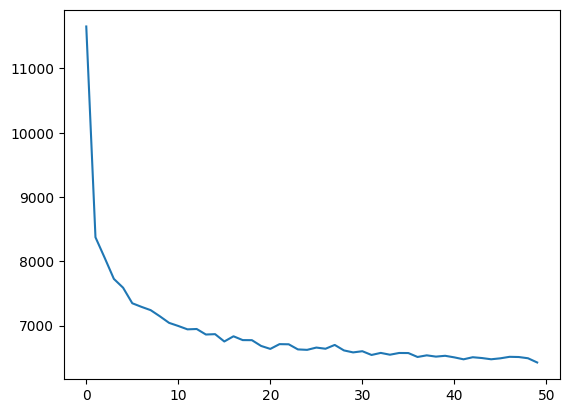

In [15]:
plt.plot(losses)